In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import os
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2
from skimage import io, transform
import matplotlib.pyplot as plt
import random
import cv2

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
## Access to the google drive
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [4]:
class Nuclie_data(Dataset):
        def __init__(self,path):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_transforms(0.5, 0.5)
        
        def __len__(self):
            return len(self.folders)
              
        
        def __getitem__(self,idx):
            image_folder = os.path.join(self.path,self.folders[idx],'images/')
            mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
            image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
            
            #convert the RGBA into RGB
            img = io.imread(image_path)[:,:,:3].astype('float32')
            img = transform.resize(img,(128,128))
            
            #mask = get_mask(mask_folder, 128, 128 ).astype('float32')
            boxes, masks = get_bounding_box(mask_folder, 128, 128 )

            # convert everything into a torch.Tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            masks = torch.as_tensor(masks, dtype=torch.float32)
            #img = torch.as_tensor(img, dtype=torch.float32)
            image_id = torch.tensor([idx])
            
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            
            #augmentation
            augmented = self.transforms(image=img)
            img = augmented['image']
            #mask = augmented['mask']
            num_objs = len(boxes)
            
            # suppose all instances are not crow
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
            
            target = {}
            target["boxes"] = boxes 

            #there is only one class 
            target["labels"] =  torch.ones((num_objs,), dtype=torch.int64)   # there is only one class
            target["masks"] = masks
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd
            
            return (img,target) 

In [5]:
##get the bounding box for each individual mask 
def get_bounding_box(mask_folder,IMG_HEIGHT, IMG_WIDTH):
    boxes = []
    masks = []
    for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder,mask_)).astype('float32')
            mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
            ###get the bounding box
            pos = np.where(mask_)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
            masks.append(mask_)
              
    return boxes, masks

In [6]:
def get_transforms(mean, std):
            list_transforms = []
            
            list_transforms.extend(
                    [
                HorizontalFlip(p=0), # only horizontal flip as of now
                    ])
            list_transforms.extend(
                    [
            Normalize(mean=mean, std=std, p=1),
            ToTensorV2(),
                    ])
            list_trfms = Compose(list_transforms)
            return list_trfms

In [7]:
#loading the datad
data_dir = '/content/MyDrive/MyDrive/stage1_train/'
data = Nuclie_data(data_dir)

In [8]:
#data size
print(data.__len__())

670


In [10]:
def combined_mask(masks,IMG_HEIGHT, IMG_WIDTH):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    masks = masks.clone().cpu().detach().numpy()
    for idx in range(len(masks)):
            mask_ = masks[idx]
            mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
            mask_ = np.expand_dims(mask_,axis=-1)
            mask = np.maximum(mask, mask_)
              
    return mask

In [15]:
def plot_box(img, box):

    colors = (255, 0, 0)
    thickness = 1
    
    for idx in range(len(box)):
        tmp_box = box[idx]
        x_min = tmp_box[0]
        y_min = tmp_box[1]
        x_max = tmp_box[2]
        y_max = tmp_box[3]
        start_point = (int(x_min), int(y_min))
        end_point = (int(x_max), int(y_max))
        if idx == 0:
           plt_box = cv2.rectangle(image_convert(img), start_point, end_point, colors, thickness)
        else:
           plt_box = cv2.rectangle(plt_box, start_point, end_point, colors, thickness)

    return plt_box

In [12]:
# converting tensor to image
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image


In [9]:
img, target = data.__getitem__(345)

<ipython-input-4-1879d57823df>:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  masks = torch.as_tensor(masks, dtype=torch.float32)


<ipython-input-10-404582ac3bec>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


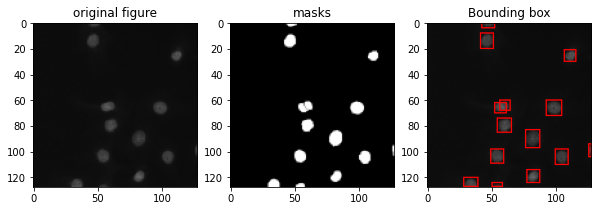

In [16]:
plt.figure(figsize=(10,6))
plt.subplot(1,3,1)
plt.title('original figure')
plt.imshow(image_convert(img))

plt.subplot(1,3,2)
plt.title('masks')
plt.imshow(combined_mask(target['masks'], 128, 128), cmap='gray')


plt.subplot(1,3,3)
plt.title('Bounding box')
plt.imshow(plot_box(img, target['boxes']))

In [17]:
import torchvision.models.segmentation
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [18]:
model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) 

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [19]:
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (nuclei) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
model.to(device)# move model to the right device

In [ ]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
model.train()

In [25]:
##### parameters setting #####
train_set = 580
batch_sizes = 1
iteration = 20
outdir = "/content/MyDrive/MyDrive/trained_model/"
##############################

loss_epoch = []
for i in range(iteration):       
    
    #how many batches used in each iteration 
    for b in range(batch_sizes):
        images = []
        targets = []
        idx=random.randint(0,train_set-1)
        image_, target_ = data.__getitem__(idx)
        images.append(image_)
        targets.append(target_)

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
    print(f"start iteration {i}")
    optimizer.zero_grad()
    loss_dict = model(images, targets)

    losses = sum(loss for loss in loss_dict.values())
    losses.backward()
    optimizer.step()
    print(i,'loss:', losses.item())
    loss_epoch.append(losses.item())
    #save model for every 100 iteration 
    if i%20==0:
       torch.save(model.state_dict(), os.path.join(outdir,str(i)+"individal_mask.torch"))

start iteration 0
0 loss: -80.91207122802734
start iteration 1
1 loss: -150.71836853027344
start iteration 2
2 loss: -206.99612426757812
start iteration 3
3 loss: -531.84765625
start iteration 4
4 loss: -457.35693359375
start iteration 5
5 loss: -713.3486938476562
start iteration 6
6 loss: -385.8846435546875
start iteration 7
7 loss: -296.2994384765625
start iteration 8
8 loss: -463.5696105957031
start iteration 9
9 loss: -654.048828125
start iteration 10
10 loss: -845.1578979492188
start iteration 11
11 loss: -732.7001342773438
start iteration 12
12 loss: -821.8690795898438
start iteration 13
13 loss: -777.0380249023438
start iteration 14
14 loss: -1756.7813720703125
start iteration 15
15 loss: -1064.68505859375
start iteration 16
16 loss: -522.977294921875
start iteration 17
17 loss: -1074.4940185546875
start iteration 18
18 loss: -1620.0738525390625
start iteration 19
19 loss: -1993.7342529296875


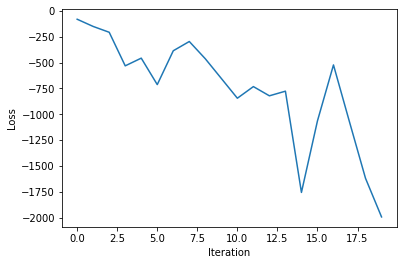

In [28]:
# Plot loss
plt.plot(list(range(len(loss_epoch))), loss_epoch)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [29]:
#load the pre-trained model 
model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) 
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes=2)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#load your model and set the model to evaluation state
model.load_state_dict(torch.load("/content/MyDrive/MyDrive/trained_model/19individal_mask.torch"))
model.eval()

In [ ]:
model.to(device)# move model to the right device

In [42]:
### get one testing image 
imag, mak = data.__getitem__(644)
img = []
img.append(imag)
img = list(image.to(device) for image in img)

In [43]:
# testing the model 
with torch.no_grad():
    pred = model(img)

In [37]:
def get_predicted_box(pred, cutoff = 0.7):
    
    filtered_box = []
    for i in range(len(pred[0]['boxes'])):
        box=pred[0]['boxes'][i].detach().cpu().numpy()
        scr=pred[0]['scores'][i].detach().cpu().numpy()
        if scr > cutoff :
           filtered_box.append(box)
    return filtered_box

In [48]:
## get all of predicted boxes 
pred_box = get_predicted_box(pred, cutoff = 0.3)
p_0 = plot_box(imag, pred_box)

In [70]:
def get_predicted_masks(pred, IMG_HEIGHT = 128, IMG_WIDTH = 128, cutoff = 0.7):
    pred_masks =pred[0]['masks']
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for idx in range(len(pred_masks)):
            scr = pred[0]['scores'][i].detach().cpu().numpy()
            if scr > cutoff :
               mask_ = pred_masks[idx].detach().cpu().numpy()
               mask_ = np.squeeze(mask_)
               mask_ = np.expand_dims(mask_,axis=-1)
               mask = np.maximum(mask, mask_)
              
    return mask

<ipython-input-70-08f1b8dd2e41>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


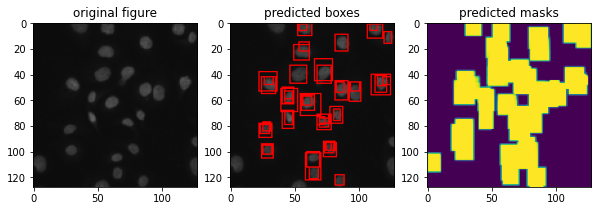

In [75]:
plt.figure(figsize=(10,6))
plt.subplot(1,3,1)
plt.title('original figure')
plt.imshow(image_convert(imag))

plt.subplot(1,3,2)
plt.title('predicted boxes')
plt.imshow(p_0)

plt.subplot(1,3,3)
plt.title('predicted masks')
plt.imshow(get_predicted_masks(pred, cutoff = 0.4))

In [64]:
pred_masks =pred[0]['masks']

In [65]:
pred_masks.size()

torch.Size([100, 1, 128, 128])

In [59]:
pred_masks.size()

torch.Size([1, 128, 128])

In [61]:
drop_pred_masks = pred_masks.clone().cpu().detach().numpy()
drop_pred_masks = np.squeeze(drop_pred_masks)